# CART on Mushroom Dataset
Kaggle竞赛蘑菇数据集，22维特征
https://www.kaggle.com/uciml/mushroom-classification

## 导入工具包

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Reading the file

调用head函数看看每个特征的基本情况

In [55]:
# path to where the data lies
dpath = './data/'
data = pd.read_csv(dpath+"mushrooms.csv")
data.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surface-below-ring  \
0            c         n          k   ...                          s   
1            c         b          k   ...                          s   
2            c         b          n   ...                          s   
3            c         n          n   ...                          s   
4            w         b          k   ...                          s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [56]:
#数据基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

很幸运，该数据没有空值／缺失数据

### 看看是否为一个两类分类问题（poisonous，edibl）

In [57]:
data['class'].unique()

array(['p', 'e'], dtype=object)

In [58]:
#观察一下数据规模
data.shape

(8124, 23)

### 特征编码

特征全是类别型变量，很多模型需要数值型的输入（Logisstic回归、xgboost...)

In [59]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in data.columns:
    data[col] = labelencoder.fit_transform(data[col])

#data.head()

LableEncoder是不合适的，因为是有序的。而颜色等特征是没有序关系。决策树等模型不care，但logistic回归不行。也可以试试OneHotEncoder

In [60]:
#X = data.iloc[:,1:23]  # all rows, all the features and no labels
#y = data.iloc[:, 0]  # all rows, label only

y = data['class']    #用列名访问更直观
X = data.drop('class', axis = 1)

### 数据集是一个文件，我们自己分出一部分来做测试吧（不是校验集）

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [62]:
columns = X_train.columns

In [63]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

## default Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

model_LR= LogisticRegression()
model_LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
# 看看各特征的系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list(abs(model_LR.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)

coef                   columns
16    [5.96372540788]                veil-color
7     [5.92830925581]                 gill-size
6     [4.88200703815]              gill-spacing
10    [4.85326886678]                stalk-root
11    [4.80786879972]  stalk-surface-above-ring
18    [4.38857063192]                 ring-type
4     [1.74345580162]                      odor
20   [0.921995173737]                population
5    [0.804395623298]           gill-attachment
8    [0.514545071491]                gill-color
1    [0.449041332657]               cap-surface
17   [0.447305010542]               ring-number
19   [0.418116313722]         spore-print-color
9    [0.393891973749]               stalk-shape
13   [0.325867942476]    stalk-color-above-ring
3    [0.230212397054]                   bruises
2    [0.202869678818]                 cap-color
21   [0.153523700489]                   habitat
14   [0.140479967772]    stalk-color-below-ring
0    [0.013292235714]                 cap-shape
12  [0.0109624399826]  stalk-surface-below-ring
15              [0.0]                 veil-type

In [66]:
y_prob = model_LR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
   
#accuracy 
print 'The accuary of default Logistic Regression is',model_LR.score(X_test, y_pred) 

The accuary of default Logistic Regression is 1.0


In [67]:
print 'The AUC of default Logistic Regression is', roc_auc_score(y_test,y_pred)

The AUC of default Logistic Regression is 0.958530571992


## Logistic Regression(Tuned model)

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置调优）和正则函数penalty（L2/L1）
目标函数为：J(theata) = sum(logloss(f(xi), yi)) + C * penalty
logistic回归: f(xi) = sigmoid(sum(wj * xj))
logloss为负log似然损失（请见课件）
L2 penalty：sum(wj^2)
L1 penalty: sum(abs(wj))

在sklearn框架下，不同学习器的参数调整步骤相同：
1. 设置候选参数集合
2. 调用GridSearchCV
3. 调用fit

In [68]:
from sklearn.linear_model import LogisticRegression

LR_model= LogisticRegression()

#设置参数搜索范围（Grid，网格）
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']
                   }

### CV

In [69]:
# fit函数执行会有点慢，因为要循环执行 参数数目 * CV折数 次模型 训练
LR= GridSearchCV(LR_model, tuned_parameters,cv=10)
LR.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
print(LR.best_params_)

{'penalty': 'l2', 'C': 100}


In [71]:
y_prob = LR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
LR.score(X_test, y_pred)

1.0

In [72]:
print 'The AUC of GridSearchCV Logistic Regression is', roc_auc_score(y_test,y_pred)

The AUC of GridSearchCV Logistic Regression is 0.972830374753


比缺省Logistic回归高了一点点

## Default Decision Tree model

In [73]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()

In [74]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
y_prob = model_tree.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_tree.score(X_test, y_pred)

1.0

In [76]:
print 'The AUC of default Desicion Tree is', roc_auc_score(y_test,y_pred)

The AUC of default Desicion Tree is 1.0


这个任务太适合决策树了

In [77]:
df = pd.DataFrame({"columns":list(columns), "importance":list(model_tree.feature_importances_.T)})
df.sort_values(by=['importance'],ascending=False)

columns  importance
8                 gill-color    0.339965
19         spore-print-color    0.208067
20                population    0.173798
7                  gill-size    0.125529
4                       odor    0.034029
3                    bruises    0.028990
9                stalk-shape    0.025458
17               ring-number    0.019775
21                   habitat    0.014852
10                stalk-root    0.012098
2                  cap-color    0.006451
18                 ring-type    0.004855
1                cap-surface    0.003961
12  stalk-surface-below-ring    0.002172
16                veil-color    0.000000
0                  cap-shape    0.000000
15                 veil-type    0.000000
14    stalk-color-below-ring    0.000000
13    stalk-color-above-ring    0.000000
6               gill-spacing    0.000000
5            gill-attachment    0.000000
11  stalk-surface-above-ring    0.000000

好像和Logistic回归选出的重要特征不一样。

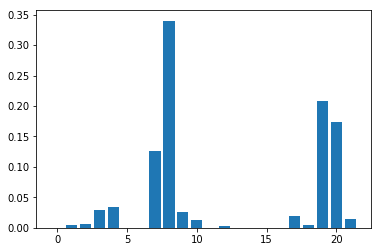

In [78]:
plt.bar(range(len(model_tree.feature_importances_)), model_tree.feature_importances_)
plt.show()

### 可根据特征重要性做特征选择

In [79]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = sort(model_tree.feature_importances_)
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(model_tree, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train)

  # train model
  selection_model = DecisionTreeClassifier()
  selection_model.fit(select_X_train, y_train)
    
# eval model
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
      accuracy*100.0))

Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.002, n=14, Accuracy: 100.00%
Thresh=0.004, n=13, Accuracy: 100.00%
Thresh=0.005, n=12, Accuracy: 100.00%
Thresh=0.006, n=11, Accuracy: 100.00%
Thresh=0.012, n=10, Accuracy: 100.00%
Thresh=0.015, n=9, Accuracy: 100.00%
Thresh=0.020, n=8, Accuracy: 99.57%
Thresh=0.025, n=7, Accuracy: 99.57%
Thresh=0.029, n=6, Accuracy: 99.57%
Thresh=0.034, n=5, Accuracy: 99.57%
Thresh=0.126, n=4, Accuracy: 98.28%
Thresh=0.174, n=3, Accuracy: 94.22%
Thresh=0.208, n=2, Accuracy: 93.05%
Thresh=0.340, n=1, Accuracy: 80.98%


In [80]:
# Fit model using the best threshhold
thresh = 0.020
selection = SelectFromModel(model_tree, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = DecisionTreeClassifier()
selection_model.fit(select_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [81]:
import graphviz
from sklearn import tree
tree.export_graphviz(model_tree, out_file='best_tree.dot') 
#$ dot -Tpng best_tree.dot -o best_tree.png 

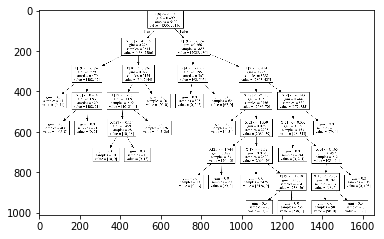

In [82]:
#import matplotlib.image as mpimg # mpimg 用于读取图片
#tree_omg = mpimg.imread('best_tree.png') 
#plt.imshow(tree_omg) # 显示图片
#plt.axis('off') # 不显示坐标轴
#plt.show()
#pip install Pillow
from PIL import Image
img=Image.open('best_tree.png')
plt.imshow(img)
plt.show()

## Let us tune the hyperparameters of the Decision tree model

决策树的超参数有：max_depth（树的深度）或max_leaf_nodes（叶子结点的数目）、max_features（最大特征数目）、min_samples_leaf（叶子结点的最小样本数）、min_samples_split（中间结点的最小样本树）、min_weight_fraction_leaf（叶子节点的样本权重占总权重的比例）
min_impurity_split（最小不纯净度）也可以调整

这个数据集的任务不难，深度设为2-10之间
两类分类问题，训练样本每类样本在3000左右，所以min_samples_leaf

In [83]:
from sklearn.tree import DecisionTreeClassifier

model_DD = DecisionTreeClassifier()

max_depth = range(1,10,1)
min_samples_leaf = range(1,10,2)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [84]:
from sklearn.model_selection import GridSearchCV
DD = GridSearchCV(model_DD, tuned_parameters,cv=10)
DD.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
print("Best: %f using %s" % (DD.best_score_, DD.best_params_))

Best: 1.000000 using {'max_depth': 7, 'min_samples_leaf': 1}


In [86]:
y_prob = DD.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
DD.score(X_test, y_pred)

1.0

In [87]:
print 'The AUC of GridSearchCV Desicion Tree is', roc_auc_score(y_test,y_pred)

The AUC of GridSearchCV Desicion Tree is 1.0


In [88]:
DD.grid_scores_

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78951, std: 0.01570, params: {'max_depth': 1, 'min_samples_leaf': 1},
 mean: 0.78951, std: 0.01570, params: {'max_depth': 1, 'min_samples_leaf': 3},
 mean: 0.78951, std: 0.01570, params: {'max_depth': 1, 'min_samples_leaf': 5},
 mean: 0.78951, std: 0.01570, params: {'max_depth': 1, 'min_samples_leaf': 7},
 mean: 0.78951, std: 0.01570, params: {'max_depth': 1, 'min_samples_leaf': 9},
 mean: 0.91091, std: 0.00787, params: {'max_depth': 2, 'min_samples_leaf': 1},
 mean: 0.91091, std: 0.00787, params: {'max_depth': 2, 'min_samples_leaf': 3},
 mean: 0.91091, std: 0.00787, params: {'max_depth': 2, 'min_samples_leaf': 5},
 mean: 0.91091, std: 0.00787, params: {'max_depth': 2, 'min_samples_leaf': 7},
 mean: 0.91091, std: 0.00787, params: {'max_depth': 2, 'min_samples_leaf': 9},
 mean: 0.95722, std: 0.00947, params: {'max_depth': 3, 'min_samples_leaf': 1},
 mean: 0.95722, std: 0.00947, params: {'max_depth': 3, 'min_samples_leaf': 3},
 mean: 0.95722, std: 0.00947, params: {'max_depth': 

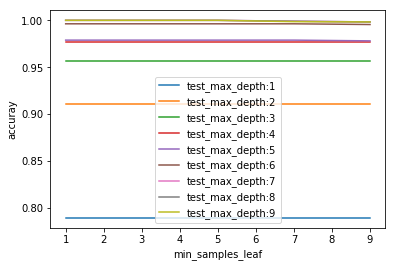

In [89]:
#DD.grid_scores_

test_means = DD.cv_results_[ 'mean_test_score' ]
#test_stds = DD.cv_results_[ 'std_test_score' ]
#pd.DataFrame(DD.cv_results_).to_csv('DD_min_samples_leaf_maxdepth.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_samples_leaf))

for i, value in enumerate(max_depth):
    plt.plot(min_samples_leaf, test_scores[i], label= 'test_max_depth:'   + str(value))

    
plt.legend()
plt.xlabel( 'min_samples_leaf' )                                                                                                      
plt.ylabel( 'accuray' )
plt.show()

## Default Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier

model_RR=RandomForestClassifier()

In [91]:
model_RR.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
y_prob = model_RR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_RR.score(X_test, y_pred)

1.0

In [93]:
print 'The AUC of default Random Forest is', roc_auc_score(y_test,y_pred)

The AUC of default Random Forest is 1.0


## Let us tuned the parameters of Random Forest just for the purpose of knowledge
1) n_estimators 2) min_sample_leaf

随机森林可调整的超参数（除了和决策树相同的参数）：n_estimators（弱学习器的数目）

In [94]:
from sklearn.ensemble import RandomForestClassifier

model_RR=RandomForestClassifier()

tuned_parameters = {'min_samples_leaf': range(1,10,2), 'n_estimators' : range(1,10,2) }

In [95]:
from sklearn.model_selection import GridSearchCV
RR = GridSearchCV(model_RR, tuned_parameters,cv=10)

In [96]:
RR.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 3, 5, 7, 9], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
print(RR.grid_scores_)

[mean: 0.99923, std: 0.00158, params: {'n_estimators': 1, 'min_samples_leaf': 1}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 3, 'min_samples_leaf': 1}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 5, 'min_samples_leaf': 1}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 7, 'min_samples_leaf': 1}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 9, 'min_samples_leaf': 1}, mean: 0.99862, std: 0.00200, params: {'n_estimators': 1, 'min_samples_leaf': 3}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 3, 'min_samples_leaf': 3}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 5, 'min_samples_leaf': 3}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 7, 'min_samples_leaf': 3}, mean: 1.00000, std: 0.00000, params: {'n_estimators': 9, 'min_samples_leaf': 3}, mean: 0.99800, std: 0.00229, params: {'n_estimators': 1, 'min_samples_leaf': 5}, mean: 0.99938, std: 0.00102, params: {'n_estimators': 3, 'min_samples_leaf': 5}, mean: 0.99923, std: 0.00157

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [98]:
print(RR.best_score_)

1.0


In [99]:
print(RR.best_params_)

{'n_estimators': 3, 'min_samples_leaf': 1}


In [100]:
y_prob = RR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
RR.score(X_test, y_pred)

1.0

In [101]:
auc_roc=roc_auc_score(y_test,y_pred)
auc_roc

1.0

## xgboost

In [103]:
## Default XGBoost
from xgboost import XGBClassifier
model_XGB=XGBClassifier()

model_XGB.fit(X_train,y_train)

y_prob = model_XGB.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_XGB.score(X_test, y_pred)

auc_roc=roc_auc_score(y_test,y_pred)
auc_roc

1.0

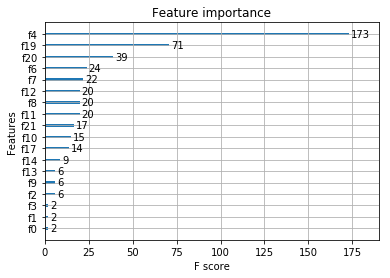

In [106]:
### 特征重要性
#可以使用XGBoost内嵌的函数，按特征重要性排序
from xgboost import plot_importance
plot_importance(model_XGB)
plt.show()

In [107]:
#可以根据特征重要性进行特征选择
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = sort(model_XGB.feature_importances_)
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train)
  # train model
  selection_model = XGBClassifier()
  selection_model.fit(select_X_train, y_train)
# eval model
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
      accuracy*100.0))

Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.004, n=18, Accuracy: 100.00%
Thresh=0.004, n=18, Accuracy: 100.00%
Thresh=0.004, n=18, Accuracy: 100.00%
Thresh=0.013, n=15, Accuracy: 100.00%
Thresh=0.013, n=15, Accuracy: 100.00%
Thresh=0.013, n=15, Accuracy: 100.00%
Thresh=0.019, n=12, Accuracy: 100.00%
Thresh=0.030, n=11, Accuracy: 100.00%
Thresh=0.032, n=10, Accuracy: 100.00%
Thresh=0.036, n=9, Accuracy: 100.00%
Thresh=0.043, n=8, Accuracy: 100.00%
Thresh=0.043, n=8, Accuracy: 100.00%
Thresh=0.043, n=8, Accuracy: 100.00%
Thresh=0.047, n=5, Accuracy: 100.00%
Thresh=0.051, n=4, Accuracy: 99.51%
Thresh=0.083, n=3, Accuracy: 99.45%
Thresh=0.152, n=2, Accuracy: 99.45%
Thresh=0.370, n=1, Accuracy: 98.58%
